# Master Notebook: Multi-Horizon State-Conditioned Return Prediction

**Goal**: Sweep over horizons H ∈ {1,2,5,10} and target bin counts N ∈ {10,20,35,55}, training both a state-conditioned and state-free neural model for each, comparing against statistical baselines (marginal, additive smoothing, backoff mixture), and producing paper-ready figures and tables.

**Definitions**:
- $P_t$ = adjusted close at trading day $t$
- $R_t^{(h)} = (P_{t+h} - P_t) / P_t$ = horizon-$h$ return (raw fraction)
- $X_t$ = quantile discretization of 1-day return $r_t$ (max duplicate-free bins ≤ 55), fit on TRAIN only
- $y_t^{(h,N)} = D_{h,N}(R_t^{(h)})$ = quantile-$N$ discretization of horizon-$h$ return, fit on TRAIN only
- State-conditioned model: $p(y_t | X_t, F_t)$ with input $[\text{one\_hot}(X_t, N_{XT}); F_t]$
- State-free model (ablation): $p(y_t | F_t)$

## 1. Setup + Imports + Seeds

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Ensure we run from repo root (handles running from notebooks/ directory)
REPO_ROOT = Path(__file__).resolve().parent.parent if "__file__" in dir() else Path.cwd()
if REPO_ROOT.name == "notebooks":
    REPO_ROOT = REPO_ROOT.parent
os.chdir(REPO_ROOT)
print(f"Working directory: {Path.cwd()}")

# Reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {DEVICE}")

# ── Experiment grid ──
HORIZONS = [1, 2, 5, 10]
N_BINS_LIST = [10, 20, 35, 55]
N_XT_TARGET = 55  # requested X_t bins (may be lowered if duplicates arise)

# ── Architecture ──
HIDDEN_DIMS = (64, 128, 256, 128, 64)
DROPOUT = 0.2

# ── Training ──
LR = 1e-3
WEIGHT_DECAY = 1e-4
BATCH_TRAIN = 256
BATCH_EVAL = 512
MAX_EPOCHS = 100
PATIENCE = 10
GRAD_CLIP = 1.0
SIGMA_ANCHOR = 1.0  # sigma at anchor N (=55)
EPS = 1e-8

# ── Baseline hyperparameter grids ──
ALPHA_GRID = [1e-6, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 5.0, 10.0]
TAU_GRID = [10, 50, 100, 200, 500, 1000]

# ── Output paths ──
FIGURES_DIR = Path("figures/master")
RESULTS_DIR = Path("results")
FIGURES_DIR.mkdir(parents=True, exist_ok=True)
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

print("Configuration:")
print(f"  Horizons:       {HORIZONS}")
print(f"  N bins (target):{N_BINS_LIST}")
print(f"  N_XT target:    {N_XT_TARGET} (will be lowered if quantile edges have duplicates)")
print(f"  LR={LR}, WD={WEIGHT_DECAY}, epochs={MAX_EPOCHS}, patience={PATIENCE}")
print(f"  Sigma anchor: {SIGMA_ANCHOR} at N={max(N_BINS_LIST)}")

Working directory: /Users/JanRovirosaIlla/DeepMarkovResearch
Device: cpu
Configuration:
  Horizons:       [1, 2, 5, 10]
  N bins (target):[10, 20, 35, 55]
  N_XT target:    55 (will be lowered if quantile edges have duplicates)
  LR=0.001, WD=0.0001, epochs=100, patience=10
  Sigma anchor: 1.0 at N=55


## 2. Data Loading + Schema Inspection

In [2]:
# Load primary dataset
train_df = pd.read_csv("dataset/train_diagnostic.csv")
labels_df = pd.read_csv("dataset/label_diagnostic.csv")

print(f"train_diagnostic.csv: {train_df.shape}")
print(f"label_diagnostic.csv: {labels_df.shape}")
print(f"\nColumns ({len(train_df.columns)}): {list(train_df.columns[:10])} ... {list(train_df.columns[-5:])}")
print(f"Label columns: {list(labels_df.columns)}")

# Drop Opinion (has NaN)
if "Opinion" in train_df.columns:
    train_df = train_df.drop(columns=["Opinion"])
    print("Dropped 'Opinion' column (contains NaN).")

# Extract prices
assert "Price" in train_df.columns, "Price column not found!"
prices = train_df["Price"].values.astype(np.float64)
print(f"\nPrices: {len(prices)} values, range [{prices.min():.4f}, {prices.max():.4f}]")

# Extract features (exclude index, Percent_change_forward, Backward_Bin, Price)
drop_feature_cols = ["index", "Percent_change_forward", "Backward_Bin", "Price"]
feature_cols = [c for c in train_df.columns if c not in drop_feature_cols]
F_all_raw = train_df[feature_cols].values.astype(np.float32)
n_features = F_all_raw.shape[1]
print(f"Features: {n_features} columns")
print(f"Feature columns: {feature_cols[:10]} ...")

# Backward_Bin diagnostic inspection
if "Backward_Bin" in train_df.columns:
    bb = train_df["Backward_Bin"].values
    bb_min, bb_max = bb.min(), bb.max()
    if bb_min == 0 and bb_max == 54:
        print(f"\nBackward_Bin: 0-based [0, 54] (n_unique={len(np.unique(bb))})")
        backward_bin_0based = bb
    elif bb_min == 1 and bb_max == 55:
        print(f"\nBackward_Bin: 1-based [1, 55] → converting to 0-based for diagnostics")
        backward_bin_0based = bb - 1
    else:
        print(f"\nBackward_Bin: INCONSISTENT range [{bb_min}, {bb_max}] — flagged, not used")
        backward_bin_0based = None
else:
    backward_bin_0based = None
    print("\nBackward_Bin column not found.")

# label_diagnostic.csv cross-check (range/distribution only)
fwd_bin = labels_df.iloc[:, 0].values
print(f"\nlabel_diagnostic.csv Forward_Bin: range [{fwd_bin.min()}, {fwd_bin.max()}], "
      f"n_unique={len(np.unique(fwd_bin))}")
print(f"Forward_Bin distribution (first 10 bins): {np.bincount(fwd_bin, minlength=60)[:10]}")
# Discard — not used for modeling
del labels_df, fwd_bin

train_diagnostic.csv: (2369, 198)
label_diagnostic.csv: (2369, 1)

Columns (198): ['index', 'Price', 'Percent_change_backward', 'Backward_Bin', 'CVol', 'Change.x', '% Change', '% Return', 'Total Return (Gross)', 'Cumulative Return %'] ... ['Tangible Equity', 'Tangible Assets', 'Opinion', 'HY_bond_rate', 'IG_bond_rate']
Label columns: ['Forward_Bin']
Dropped 'Opinion' column (contains NaN).

Prices: 2369 values, range [53.0700, 288.7500]
Features: 194 columns
Feature columns: ['Percent_change_backward', 'CVol', 'Change.x', '% Change', '% Return', 'Total Return (Gross)', 'Cumulative Return %', 'Open', 'High', 'Low'] ...

Backward_Bin: 1-based [1, 55] → converting to 0-based for diagnostics

label_diagnostic.csv Forward_Bin: range [1, 55], n_unique=53
Forward_Bin distribution (first 10 bins): [ 0  3  0  3  1  5  5  6 19 12]


## 3. Compute X_t (Current State) — Quantile Bins of 1-Day Returns

In [3]:
# Compute 1-day returns: r_t = (P_{t+1} - P_t) / P_t for t=0..2367
r_1day_all = (prices[1:] - prices[:-1]) / prices[:-1]  # length = len(prices) - 1
print(f"1-day returns: {len(r_1day_all)} values")
print(f"  range: [{r_1day_all.min():.6f}, {r_1day_all.max():.6f}]")
print(f"  mean:  {r_1day_all.mean():.6f}, std: {r_1day_all.std():.6f}")

# Fit X_t edges ONCE on h=1 TRAIN window
T_1day = len(r_1day_all)
train_end_h1 = int(0.7 * T_1day)
r_1day_train = r_1day_all[:train_end_h1]
print(f"\nX_t training window: first {train_end_h1} of {T_1day} 1-day returns")

# Fit N_XT_TARGET quantile edges on h=1 TRAIN window
edges_xt_raw = np.quantile(r_1day_train, np.linspace(0, 1, N_XT_TARGET + 1))

# Compute effective unique bins BEFORE setting ±inf (all values are finite at this point)
effective_xt = len(np.unique(edges_xt_raw[np.isfinite(edges_xt_raw)])) - 1

if effective_xt == N_XT_TARGET:
    N_XT_FINAL = N_XT_TARGET
    edges_xt = edges_xt_raw.copy()
    edges_xt[0] = -np.inf
    edges_xt[-1] = np.inf
    print(f"N_XT_FINAL = {N_XT_FINAL} (all {N_XT_TARGET} bins retained, no ties detected)")
else:
    N_XT_FINAL = effective_xt
    # Deduplicate edges from the SAME fit — do NOT refit with fewer quantile points.
    # unique_edges has N_XT_FINAL+1 values; interior = unique_edges[1:-1] (N_XT_FINAL-1 values).
    # Final edges_xt: [-inf, N_XT_FINAL-1 interior breakpoints, +inf] → N_XT_FINAL bins.
    unique_edges = np.unique(edges_xt_raw[np.isfinite(edges_xt_raw)])
    edges_xt = np.concatenate([[-np.inf], unique_edges[1:-1], [np.inf]])
    print(f"\nINFO: Requested N_XT_TARGET={N_XT_TARGET} X_t bins.")
    print(f"  Duplicate quantile cutpoints detected: "
          f"{N_XT_TARGET - N_XT_FINAL} bin(s) collapsed to zero width (ties in training returns).")
    print(f"  Effective unique bins: N_XT_FINAL = {N_XT_FINAL}")
    print(f"  Using deduplicated edges from the same N_XT_TARGET fit (no jitter, no refit).")
    print(f"  Downstream one-hot dim and baseline matrices will use N_XT_FINAL = {N_XT_FINAL}.")

# Alias so all downstream cells (model defs, baselines, summary) pick up the right value
N_XT = N_XT_FINAL

print(f"\nX_t edges: {len(edges_xt)} total → {N_XT_FINAL} bins")

# Assign X_t for all time points
X_t_all = np.clip(np.digitize(r_1day_all, edges_xt) - 1, 0, N_XT_FINAL - 1)

# ── Sanity check ──
xt_counts = np.bincount(X_t_all, minlength=N_XT_FINAL)
print(f"\n--- X_t Sanity Check ---")
print(f"  N_XT_TARGET : {N_XT_TARGET}")
print(f"  N_XT_FINAL  : {N_XT_FINAL}")
print(f"  X_t_all min : {X_t_all.min()},  max : {X_t_all.max()}")
print(f"  Bin counts  : min={xt_counts.min()}, max={xt_counts.max()}, zeros={np.sum(xt_counts == 0)}")
assert X_t_all.min() >= 0, f"X_t_all min={X_t_all.min()} < 0"
assert X_t_all.max() <= N_XT_FINAL - 1, f"X_t_all max={X_t_all.max()} > {N_XT_FINAL - 1}"
print(f"  PASS: X_t_all ∈ [0, {N_XT_FINAL - 1}]")

# Diagnostic: compare X_t vs Backward_Bin
if backward_bin_0based is not None:
    bb_aligned = backward_bin_0based[:len(X_t_all)]
    n_bb = int(bb_aligned.max()) + 1
    contingency = np.zeros((N_XT_FINAL, n_bb), dtype=np.int64)
    for xt_val, bb_val in zip(X_t_all, bb_aligned):
        contingency[xt_val, bb_val] += 1
    contingency_norm = contingency / contingency.sum()
    print(f"\nX_t vs Backward_Bin contingency: shape {contingency.shape}")
    print(f"  Diagonal mass (if aligned): "
          f"{sum(contingency_norm[i,i] for i in range(min(N_XT_FINAL, n_bb))):.4f}")
    p_xy = contingency_norm + EPS
    p_x = p_xy.sum(axis=1, keepdims=True)
    p_y = p_xy.sum(axis=0, keepdims=True)
    mi = (p_xy * np.log(p_xy / (p_x * p_y))).sum()
    print(f"  MI(X_t_quant{N_XT_FINAL}, Backward_Bin) = {mi:.4f} nats")

# Save X_t edges
save_name = f"bin_edges_state_X_quant{N_XT_FINAL}.csv"
pd.DataFrame({"edge": edges_xt}).to_csv(RESULTS_DIR / save_name, index=False)
print(f"\nX_t edges saved to {RESULTS_DIR / save_name}")

1-day returns: 2368 values
  range: [-0.149649, 0.180125]
  mean:  0.000827, std: 0.017659

X_t training window: first 1657 of 2368 1-day returns
N_XT_FINAL = 55 (all 55 bins retained, no ties detected)

X_t edges: 56 total → 55 bins

--- X_t Sanity Check ---
  N_XT_TARGET : 55
  N_XT_FINAL  : 55
  X_t_all min : 0,  max : 54
  Bin counts  : min=34, max=54, zeros=0
  PASS: X_t_all ∈ [0, 54]

X_t vs Backward_Bin contingency: shape (55, 55)
  Diagonal mass (if aligned): 0.0245
  MI(X_t_quant55, Backward_Bin) = 0.5792 nats

X_t edges saved to results/bin_edges_state_X_quant55.csv


## 4. Sanity Checks: Returns vs Existing Data

In [4]:
# Compare computed 1-day returns vs Percent_change_forward if it exists
if "Percent_change_forward" in train_df.columns:
    pcf = train_df["Percent_change_forward"].values
    # pcf is in percentage, r_1day_all is raw fraction
    # Align: pcf has 2369 rows, r_1day_all has 2368
    pcf_aligned = pcf[:len(r_1day_all)]
    computed_pct = r_1day_all * 100.0  # convert to percentage for comparison
    
    # Check scaling
    valid_mask = np.isfinite(pcf_aligned) & np.isfinite(computed_pct) & (np.abs(computed_pct) > 1e-10)
    if valid_mask.any():
        ratio = pcf_aligned[valid_mask] / computed_pct[valid_mask]
        median_ratio = np.median(ratio)
        print(f"Scaling check: median(Percent_change_forward / computed_pct) = {median_ratio:.6f}")
        print(f"  (expected ~1.0 if both in same units)")
    
    # Correlation
    valid_both = np.isfinite(pcf_aligned) & np.isfinite(computed_pct)
    corr = np.corrcoef(pcf_aligned[valid_both], computed_pct[valid_both])[0, 1]
    
    # Mean abs diff in fraction space
    diff_frac = np.abs(pcf_aligned[valid_both] / 100.0 - r_1day_all[valid_both])
    mean_abs_diff = diff_frac.mean()
    max_abs_diff = diff_frac.max()
    
    print(f"\nCorrelation: {corr:.8f}")
    print(f"Mean abs diff (fraction space): {mean_abs_diff:.2e}")
    print(f"Max abs diff (fraction space):  {max_abs_diff:.2e}")
    
    # Preview
    print(f"\nFirst 10 rows comparison:")
    preview = pd.DataFrame({
        "Percent_change_forward": pcf_aligned[:10],
        "computed_pct": computed_pct[:10],
        "diff_frac": (pcf_aligned[:10]/100.0 - r_1day_all[:10])
    })
    print(preview.to_string())
    
    # STOP check
    if corr < 0.98 or mean_abs_diff > 1e-3:
        raise ValueError(
            f"MISMATCH: corr={corr:.4f}, mean_abs_diff={mean_abs_diff:.2e}. "
            f"Cannot proceed — please verify which source defines returns."
        )
    else:
        print(f"\nSanity check PASSED: returns match (corr={corr:.6f}, mean_diff={mean_abs_diff:.2e})")
else:
    print("Percent_change_forward column not found — skipping cross-check.")
    print("Proceeding with Price-computed returns.")

Percent_change_forward column not found — skipping cross-check.
Proceeding with Price-computed returns.


## 5. Chronological Splits + Sanity Checks

In [5]:
# For each horizon h, valid t in {0, ..., 2368-h}  (length 2369-h)
# Prices indexed 0..2368 (2369 values)
# X_t exists for t=0..2367 (2368 values), covers all valid t for h in {1,2,5,10}

splits = {}
print(f"{'h':>3}  {'T_h':>6}  {'train':>6}  {'val':>5}  {'test':>5}")
print("-" * 35)

for h in HORIZONS:
    T_h = 2369 - h  # = len(prices) - h
    train_end = int(0.7 * T_h)
    val_end = int(0.85 * T_h)
    
    idx_train = np.arange(0, train_end)
    idx_val = np.arange(train_end, val_end)
    idx_test = np.arange(val_end, T_h)
    
    splits[h] = {"T_h": T_h, "train_end": train_end, "val_end": val_end,
                 "idx_train": idx_train, "idx_val": idx_val, "idx_test": idx_test}
    
    print(f"{h:>3}  {T_h:>6}  {len(idx_train):>6}  {len(idx_val):>5}  {len(idx_test):>5}")
    
    # Verify no overlap
    assert idx_train[-1] < idx_val[0], f"h={h}: train/val overlap!"
    assert idx_val[-1] < idx_test[0], f"h={h}: val/test overlap!"
    assert idx_test[-1] < len(X_t_all), f"h={h}: test exceeds X_t range!"

  h     T_h   train    val   test
-----------------------------------
  1    2368    1657    355    356
  2    2367    1656    355    356
  5    2364    1654    355    355
 10    2359    1651    354    354


## 6. Feature Preprocessing

In [6]:
# Fit z-score ONCE on h=1 TRAIN indices, reuse for all horizons
idx_train_h1 = splits[1]["idx_train"]
F_train_h1 = F_all_raw[idx_train_h1]

feat_mean = F_train_h1.mean(axis=0, keepdims=True)
feat_std = F_train_h1.std(axis=0, keepdims=True) + EPS

F_all_normed = ((F_all_raw - feat_mean) / feat_std).astype(np.float32)

print(f"Z-score stats fit on h=1 TRAIN ({len(idx_train_h1)} samples)")
print(f"  mean range: [{feat_mean.min():.4f}, {feat_mean.max():.4f}]")
print(f"  std  range: [{feat_std.min():.4f}, {feat_std.max():.4f}]")

# Check for NaN/Inf
n_nan = np.isnan(F_all_normed).sum()
n_inf = np.isinf(F_all_normed).sum()
print(f"  NaN count: {n_nan}, Inf count: {n_inf}")
if n_nan > 0 or n_inf > 0:
    print("  WARNING: NaN/Inf detected in normalized features!")
    # Replace NaN/Inf with 0
    F_all_normed = np.nan_to_num(F_all_normed, nan=0.0, posinf=0.0, neginf=0.0)
    print("  Replaced NaN/Inf with 0.")

Z-score stats fit on h=1 TRAIN (1657 samples)
  mean range: [-16244.1631, 28850572.0000]
  std  range: [0.0378, 6681060.5000]
  NaN count: 0, Inf count: 0


In [7]:
# Alignment check: for each h, print first 5 valid t
def compute_returns(prices, h):
    """R_t^(h) = (P_{t+h} - P_t) / P_t for t = 0..len(prices)-1-h"""
    return (prices[h:] - prices[:-h]) / prices[:-h]

print("Alignment check (first 5 t per horizon):")
for h in HORIZONS:
    R_h = compute_returns(prices, h)
    # Use N=10 edges from train for quick preview
    sp = splits[h]
    R_train = R_h[sp["idx_train"]]
    edges_preview = np.quantile(R_train, np.linspace(0, 1, 11))
    edges_preview[0] = -np.inf
    edges_preview[-1] = np.inf
    y_preview = np.clip(np.digitize(R_h, edges_preview) - 1, 0, 9)
    
    print(f"\n  h={h}:")
    print(f"  {'t':>4}  {'P_t':>10}  {'P_{t+h}':>10}  {'R_t^(h)':>12}  {'X_t':>4}  {'y_t(N=10)':>10}")
    for t in range(5):
        print(f"  {t:>4}  {prices[t]:>10.4f}  {prices[t+h]:>10.4f}  {R_h[t]:>12.6f}  {X_t_all[t]:>4}  {y_preview[t]:>10}")

Alignment check (first 5 t per horizon):

  h=1:
     t         P_t     P_{t+h}       R_t^(h)   X_t   y_t(N=10)
     0     58.9600     57.3400     -0.027476     2           0
     1     57.3400     58.2000      0.014998    47           8
     2     58.2000     57.0400     -0.019931     4           0
     3     57.0400     57.0100     -0.000526    26           4
     4     57.0100     55.5100     -0.026311     2           0

  h=2:
     t         P_t     P_{t+h}       R_t^(h)   X_t   y_t(N=10)
     0     58.9600     58.2000     -0.012890     2           2
     1     57.3400     57.0400     -0.005232    47           3
     2     58.2000     57.0100     -0.020447     4           1
     3     57.0400     55.5100     -0.026823    26           0
     4     57.0100     55.2500     -0.030872     2           0

  h=5:
     t         P_t     P_{t+h}       R_t^(h)   X_t   y_t(N=10)
     0     58.9600     55.5100     -0.058514     2           0
     1     57.3400     55.2500     -0.036449    47   

## 7. Helper Functions

In [8]:
# ════════════════════════════════════════════
# NEW: Return / binning / sigma helpers
# ════════════════════════════════════════════

def compute_quantile_edges(returns_train, N):
    """Fit N quantile bin edges on training returns.
    Returns array of N+1 edges with -inf/+inf at boundaries."""
    edges = np.quantile(returns_train, np.linspace(0, 1, N + 1))
    edges[0] = -np.inf
    edges[-1] = np.inf
    return edges


def assign_bins(returns, edges):
    """Digitize returns into bins [0, N-1]."""
    N = len(edges) - 1
    return np.clip(np.digitize(returns, edges) - 1, 0, N - 1)


def effective_bins_raw(R_train, N):
    """Compute the number of duplicate-free bins achievable with N quantile bins.

    Uses RAW quantile edges (before ±inf replacement) so the formula
    len(unique(raw)) - 1 is correct:
      - raw has N+1 values; if all unique → effective = N
      - each duplicate pair reduces effective by 1
    """
    raw = np.quantile(R_train, np.linspace(0, 1, N + 1))
    return len(np.unique(raw)) - 1


def get_edges(R_train, N_target):
    """Return (N_actual, edges) for up to N_target quantile bins.

    Auto-reduces N if duplicate quantile edges are present.
    edges has ±inf boundaries. N_actual ≤ N_target.
    """
    eff = effective_bins_raw(R_train, N_target)
    N_actual = min(N_target, eff)
    raw = np.quantile(R_train, np.linspace(0, 1, N_actual + 1))
    # One-step verification at reduced N
    eff2 = len(np.unique(raw)) - 1
    if eff2 < N_actual:
        N_actual = eff2
        raw = np.quantile(R_train, np.linspace(0, 1, N_actual + 1))
    edges = raw.copy()
    edges[0] = -np.inf
    edges[-1] = np.inf
    return N_actual, edges


def compute_sigma(edges_target, edges_anchor, sigma_anchor=1.0):
    """Sigma scaling: sigma_N = sigma_anchor * (median_width_anchor / median_width_target).
    Uses finite interior edges to compute bin widths in return space."""
    finite_t = edges_target[np.isfinite(edges_target)]
    finite_a = edges_anchor[np.isfinite(edges_anchor)]
    widths_t = np.diff(finite_t)
    widths_a = np.diff(finite_a)
    delta_t = np.median(widths_t) if len(widths_t) > 0 else 1.0
    delta_a = np.median(widths_a) if len(widths_a) > 0 else 1.0
    return sigma_anchor * (delta_a / delta_t)


# ════════════════════════════════════════════
# REUSED: Soft label generation
# (from TransitionProbMatrix_NEWDATA.ipynb)
# ════════════════════════════════════════════

def create_soft_labels_batch(y_hard, n_states, kernel="gaussian", sigma=2.0, radius=3, eps=1e-8):
    """Convert hard integer labels to soft probability distributions over bins."""
    batch_size = y_hard.shape[0]
    device = y_hard.device
    dtype = torch.float32
    j = torch.arange(n_states, device=device, dtype=dtype).unsqueeze(0).expand(batch_size, -1)
    y_expanded = y_hard.unsqueeze(1).float()
    if kernel == "gaussian":
        distances_sq = (j - y_expanded) ** 2
        unnormalized = torch.exp(-distances_sq / (2 * sigma ** 2))
    elif kernel == "triangular":
        distances = torch.abs(j - y_expanded)
        unnormalized = torch.clamp(1.0 - distances / (radius + 1), min=0.0)
    else:
        raise ValueError(f"Unknown kernel: {kernel}")
    soft_targets = unnormalized / (unnormalized.sum(dim=1, keepdim=True) + eps)
    return soft_targets


def compute_expected_bin(probs, n_states):
    """E[j] = sum_j p[j] * j"""
    device = probs.device
    bins = torch.arange(n_states, device=device, dtype=probs.dtype)
    return (probs * bins).sum(dim=1)


def compute_bin_severity(pred_bins, true_bins):
    """Mean |pred_bin - true_bin|"""
    return torch.abs(pred_bins - true_bins.float()).mean().item()


# ════════════════════════════════════════════
# REUSED: Baseline functions
# (from DiagnosticExperiment_v3_val_tuned.ipynb)
# ════════════════════════════════════════════

def compute_marginal(y, n_classes):
    """Compute marginal distribution from integer labels."""
    counts = np.bincount(y, minlength=n_classes).astype(np.float64)
    return counts / counts.sum()


def compute_joint_counts(s, y, n_x, n_y):
    """Compute raw joint count matrix C[x, y]."""
    C = np.zeros((n_x, n_y), dtype=np.float64)
    for si, yi in zip(s, y):
        C[si, yi] += 1
    return C


def compute_conditional_additive(s, y, n_x, n_y, alpha, marginal_fallback=None):
    """P(y|x) = (C[x,y] + alpha) / (C[x,.] + alpha * n_y)."""
    C = compute_joint_counts(s, y, n_x, n_y)
    if alpha == 0:
        row_sums = C.sum(axis=1)
        P = np.zeros_like(C)
        for i in range(n_x):
            if row_sums[i] > 0:
                P[i] = C[i] / row_sums[i]
            elif marginal_fallback is not None:
                P[i] = marginal_fallback
            else:
                P[i] = 1.0 / n_y
        return P
    C_alpha = C + alpha
    return C_alpha / C_alpha.sum(axis=1, keepdims=True)


def build_backoff_matrix(s_train, y_train, n_x, n_y, alpha, tau, marginal):
    """A[x,y] = lam_x * P_cond(y|x) + (1-lam_x) * P_marg(y)
    where lam_x = count(x) / (count(x) + tau)."""
    C = compute_joint_counts(s_train, y_train, n_x, n_y)
    C_alpha = C + alpha
    P_cond = C_alpha / C_alpha.sum(axis=1, keepdims=True)
    state_counts = C.sum(axis=1)
    lam = state_counts / (state_counts + tau)
    A = np.zeros((n_x, n_y), dtype=np.float64)
    for i in range(n_x):
        A[i] = lam[i] * P_cond[i] + (1 - lam[i]) * marginal
    return A, lam, P_cond


def mean_log_likelihood(pred_dist, y_true):
    """Mean log P(y_true) under predicted distribution."""
    N = len(y_true)
    probs = pred_dist[np.arange(N), y_true]
    return np.log(probs + EPS).mean()


print("All helper functions defined.")

All helper functions defined.


## 8. Precompute All (h, N) Configurations

In [9]:
configs = {}          # keyed by (h, N_requested)
effective_N_map = {}  # (h, N_requested) -> N_actual

print(f"{'h':>3}  {'N_req':>5}  {'N_eff':>5}  {'T_h':>5}  {'train':>5}  "
      f"{'val':>4}  {'test':>4}  {'sigma':>8}")
print("-" * 62)

for h in HORIZONS:
    R_h = compute_returns(prices, h)
    sp = splits[h]
    R_train = R_h[sp["idx_train"]]

    # ── Anchor edges: largest N in grid, auto-reduce if dups ──
    anchor_N_req = max(N_BINS_LIST)
    anchor_N_act, edges_anchor_h = get_edges(R_train, anchor_N_req)
    if anchor_N_act < anchor_N_req:
        print(f"  [h={h}] Anchor N={anchor_N_req} → {anchor_N_act} (duplicate edges removed)")

    for N in N_BINS_LIST:
        N_actual, edges = get_edges(R_train, N)
        if N_actual < N:
            print(f"  [h={h}, N={N}] Duplicate edges → N_actual={N_actual}")

        effective_N_map[(h, N)] = N_actual
        y_all_hN = assign_bins(R_h, edges)
        sigma = compute_sigma(edges, edges_anchor_h, SIGMA_ANCHOR)

        configs[(h, N)] = {
            "R_h":      R_h,
            "y_all":    y_all_hN,
            "edges":    edges,
            "sigma":    sigma,
            "N_actual": N_actual,
            "T_h":      sp["T_h"],
            "idx_train": sp["idx_train"],
            "idx_val":   sp["idx_val"],
            "idx_test":  sp["idx_test"],
        }

        print(f"{h:>3}  {N:>5}  {N_actual:>5}  {sp['T_h']:>5}  "
              f"{len(sp['idx_train']):>5}  {len(sp['idx_val']):>4}  "
              f"{len(sp['idx_test']):>4}  {sigma:>8.4f}")

        pd.DataFrame({"edge": edges}).to_csv(
            RESULTS_DIR / f"bin_edges_h{h}_N{N_actual}.csv", index=False
        )

print(f"\nTotal configurations: {len(configs)}")
print(f"Bin edge files saved to {RESULTS_DIR}/")

reductions = {k: v for k, v in effective_N_map.items() if v != k[1]}
if reductions:
    print(f"\nWARNING: {len(reductions)} config(s) had N reduced due to duplicate edges:")
    for (h, N_req), N_eff in sorted(reductions.items()):
        print(f"  h={h}, N_requested={N_req} → N_actual={N_eff}")

  h  N_req  N_eff    T_h  train   val  test     sigma
--------------------------------------------------------------
  1     10     10   2368   1657   355   356    0.2110
  1     20     20   2368   1657   355   356    0.3882
  1     35     35   2368   1657   355   356    0.6741
  1     55     55   2368   1657   355   356    1.0000
  2     10     10   2367   1656   355   356    0.1919
  2     20     20   2367   1656   355   356    0.3660
  2     35     35   2367   1656   355   356    0.6280
  2     55     55   2367   1656   355   356    1.0000
  5     10     10   2364   1654   355   355    0.2025
  5     20     20   2364   1654   355   355    0.3947
  5     35     35   2364   1654   355   355    0.6094
  5     55     55   2364   1654   355   355    1.0000
 10     10     10   2359   1651   354   354    0.1985
 10     20     20   2359   1651   354   354    0.3784
 10     35     35   2359   1651   354   354    0.6416
 10     55     55   2359   1651   354   354    1.0000

Total configuratio

## 9. FINAL SANITY SUMMARY

In [10]:
print("=" * 60)
print("FINAL SANITY SUMMARY")
print("=" * 60)
print(f"Price column: 'Price' from dataset/train_diagnostic.csv")
print(f"Feature count: {n_features}")
print(f"X_t: quantile-{N_XT} of 1-day returns, fit on h=1 TRAIN ({train_end_h1} samples)")
print(f"  (requested {N_XT_TARGET}, got {N_XT} duplicate-free bins)")
print(f"Normalization: z-score fit on h=1 TRAIN, applied globally")

if backward_bin_0based is not None:
    bb_min, bb_max = backward_bin_0based.min(), backward_bin_0based.max()
    print(f"Backward_Bin (diagnostics only): 0-based [{bb_min}, {bb_max}]")

print(f"\n{'h':>3}  {'N_req':>5}  {'N_eff':>5}  {'sigma':>8}  "
      f"{'train_bins':>22}  {'test_bins':>22}")
print("-" * 72)
for (h, N), cfg in configs.items():
    N_actual = cfg["N_actual"]
    y_tr = cfg["y_all"][cfg["idx_train"]]
    y_te = cfg["y_all"][cfg["idx_test"]]
    bc_tr = np.bincount(y_tr, minlength=N_actual)
    bc_te = np.bincount(y_te, minlength=N_actual)
    print(f"{h:>3}  {N:>5}  {N_actual:>5}  {cfg['sigma']:>8.4f}  "
          f"min={bc_tr.min():>3} max={bc_tr.max():>3} mean={bc_tr.mean():>5.1f}  "
          f"min={bc_te.min():>3} max={bc_te.max():>3} mean={bc_te.mean():>5.1f}")

print("=" * 60)

FINAL SANITY SUMMARY
Price column: 'Price' from dataset/train_diagnostic.csv
Feature count: 194
X_t: quantile-55 of 1-day returns, fit on h=1 TRAIN (1657 samples)
  (requested 55, got 55 duplicate-free bins)
Normalization: z-score fit on h=1 TRAIN, applied globally
Backward_Bin (diagnostics only): 0-based [0, 54]

  h  N_req  N_eff     sigma              train_bins               test_bins
------------------------------------------------------------------------
  1     10     10    0.2110  min=165 max=166 mean=165.7  min= 23 max= 47 mean= 35.6
  1     20     20    0.3882  min= 82 max= 83 mean= 82.8  min=  9 max= 28 mean= 17.8
  1     35     35    0.6741  min= 47 max= 48 mean= 47.3  min=  3 max= 20 mean= 10.2
  1     55     55    1.0000  min= 30 max= 31 mean= 30.1  min=  1 max= 12 mean=  6.5
  2     10     10    0.1919  min=165 max=166 mean=165.6  min= 24 max= 50 mean= 35.6
  2     20     20    0.3660  min= 82 max= 83 mean= 82.8  min= 11 max= 32 mean= 17.8
  2     35     35    0.6280  mi

## 10. Dataset + DataLoader Factory

In [11]:
class MasterDataset(Dataset):
    def __init__(self, F_normed, X_t, y, indices):
        self.F = torch.tensor(F_normed[indices], dtype=torch.float32)
        self.X_t = torch.tensor(X_t[indices], dtype=torch.long)
        self.y = torch.tensor(y[indices], dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.F[idx], self.X_t[idx], self.y[idx]


def build_loaders(cfg):
    """Build train/val/test DataLoaders for a given (h, N) config."""
    train_ds = MasterDataset(F_all_normed, X_t_all, cfg["y_all"], cfg["idx_train"])
    val_ds = MasterDataset(F_all_normed, X_t_all, cfg["y_all"], cfg["idx_val"])
    test_ds = MasterDataset(F_all_normed, X_t_all, cfg["y_all"], cfg["idx_test"])
    
    train_loader = DataLoader(train_ds, batch_size=BATCH_TRAIN, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_EVAL, shuffle=False)
    test_loader = DataLoader(test_ds, batch_size=BATCH_EVAL, shuffle=False)
    
    return train_loader, val_loader, test_loader


print("Dataset and DataLoader factory defined.")

Dataset and DataLoader factory defined.


## 11. Model Definitions

In [12]:
class StateConditionedNet(nn.Module):
    """[one_hot(X_t, N_XT); F_t] -> MLP -> N logits"""
    def __init__(self, n_features, n_xt_states, n_output,
                 hidden_dims=HIDDEN_DIMS, dropout=DROPOUT):
        super().__init__()
        self.n_xt_states = n_xt_states
        layers = []
        in_dim = n_features + n_xt_states
        for h in hidden_dims:
            layers.append(nn.Linear(in_dim, h))
            layers.append(nn.GELU())
            layers.append(nn.Dropout(dropout))
            in_dim = h
        self.mlp = nn.Sequential(*layers)
        self.out = nn.Linear(in_dim, n_output)

    def forward(self, features, x_t):
        s_onehot = F.one_hot(x_t, num_classes=self.n_xt_states).float()
        z = torch.cat([s_onehot, features], dim=-1)
        h = self.mlp(z)
        return self.out(h)


class StateFreeNet(nn.Module):
    """F_t -> MLP -> N logits (no state conditioning)"""
    def __init__(self, n_features, n_output,
                 hidden_dims=HIDDEN_DIMS, dropout=DROPOUT):
        super().__init__()
        layers = []
        in_dim = n_features
        for h in hidden_dims:
            layers.append(nn.Linear(in_dim, h))
            layers.append(nn.GELU())
            layers.append(nn.Dropout(dropout))
            in_dim = h
        self.mlp = nn.Sequential(*layers)
        self.out = nn.Linear(in_dim, n_output)

    def forward(self, features, x_t_ignored=None):
        h = self.mlp(features)
        return self.out(h)


# Quick param count check (using max target N and actual N_XT)
_m = StateConditionedNet(n_features, N_XT, max(N_BINS_LIST))
print(f"StateConditionedNet (N_XT={N_XT}, out={max(N_BINS_LIST)}): "
      f"{sum(p.numel() for p in _m.parameters()):,} params")
_m = StateFreeNet(n_features, max(N_BINS_LIST))
print(f"StateFreeNet (out={max(N_BINS_LIST)}):        "
      f"{sum(p.numel() for p in _m.parameters()):,} params")
del _m

StateConditionedNet (N_XT=55, out=55): 102,071 params
StateFreeNet (out=55):        98,551 params


## 12. Training Loop Function

In [13]:
def train_one_run(model, train_loader, val_loader, N, sigma, verbose=False):
    """
    Train model with AdamW, ReduceLROnPlateau, early stopping.
    Returns: (best_state_dict, history_dict)
    """
    model = model.to(DEVICE)
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=5)
    
    best_val_loss = float("inf")
    best_state = None
    epochs_no_improve = 0
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
    
    for epoch in range(1, MAX_EPOCHS + 1):
        # ── Train ──
        model.train()
        t_loss, t_correct, t_n = 0.0, 0, 0
        for F_b, xt_b, y_b in train_loader:
            F_b, xt_b, y_b = F_b.to(DEVICE), xt_b.to(DEVICE), y_b.to(DEVICE)
            optimizer.zero_grad()
            logits = model(F_b, xt_b)
            soft = create_soft_labels_batch(y_b, N, kernel="gaussian", sigma=sigma)
            log_probs = F.log_softmax(logits, dim=1)
            loss = F.kl_div(log_probs, soft, reduction="batchmean")
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=GRAD_CLIP)
            optimizer.step()
            t_loss += loss.item() * len(y_b)
            t_correct += (logits.argmax(1) == y_b).sum().item()
            t_n += len(y_b)
        
        # ── Validate ──
        model.eval()
        v_loss, v_correct, v_n = 0.0, 0, 0
        with torch.no_grad():
            for F_b, xt_b, y_b in val_loader:
                F_b, xt_b, y_b = F_b.to(DEVICE), xt_b.to(DEVICE), y_b.to(DEVICE)
                logits = model(F_b, xt_b)
                soft = create_soft_labels_batch(y_b, N, kernel="gaussian", sigma=sigma)
                log_probs = F.log_softmax(logits, dim=1)
                loss = F.kl_div(log_probs, soft, reduction="batchmean")
                v_loss += loss.item() * len(y_b)
                v_correct += (logits.argmax(1) == y_b).sum().item()
                v_n += len(y_b)
        
        avg_t = t_loss / t_n
        avg_v = v_loss / v_n
        scheduler.step(avg_v)
        
        history["train_loss"].append(avg_t)
        history["val_loss"].append(avg_v)
        history["train_acc"].append(t_correct / t_n)
        history["val_acc"].append(v_correct / v_n)
        
        if avg_v < best_val_loss:
            best_val_loss = avg_v
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        
        if verbose and (epoch % 20 == 0 or epoch == 1):
            print(f"    epoch {epoch:>3}: train={avg_t:.4f} val={avg_v:.4f} "
                  f"t_acc={t_correct/t_n:.3f} v_acc={v_correct/v_n:.3f}")
        
        if epochs_no_improve >= PATIENCE:
            if verbose:
                print(f"    Early stop at epoch {epoch}")
            break
    
    model.load_state_dict(best_state)
    model.to(DEVICE)
    return best_state, history


def evaluate_model(model, loader, N):
    """Compute mean_ll, accuracy, severity on a DataLoader."""
    model.eval()
    all_lp, all_preds, all_true, all_exp = [], [], [], []
    bins_t = torch.arange(N, dtype=torch.float32, device=DEVICE)
    
    with torch.no_grad():
        for F_b, xt_b, y_b in loader:
            F_b, xt_b, y_b = F_b.to(DEVICE), xt_b.to(DEVICE), y_b.to(DEVICE)
            logits = model(F_b, xt_b)
            probs = F.softmax(logits, dim=1)
            
            lp = torch.log(probs[torch.arange(len(y_b), device=DEVICE), y_b] + EPS)
            all_lp.append(lp.cpu())
            all_preds.append(logits.argmax(1).cpu())
            all_true.append(y_b.cpu())
            all_exp.append((probs * bins_t).sum(1).cpu())
    
    all_lp = torch.cat(all_lp)
    all_preds = torch.cat(all_preds)
    all_true = torch.cat(all_true)
    all_exp = torch.cat(all_exp)
    
    return {
        "mean_ll": all_lp.mean().item(),
        "accuracy": (all_preds == all_true).float().mean().item(),
        "severity": torch.abs(all_exp - all_true.float()).mean().item(),
    }


print("Training and evaluation functions defined.")

Training and evaluation functions defined.


## 13. Baseline Evaluation Functions

In [14]:
def evaluate_baselines(cfg, N):
    """Evaluate marginal, additive, and backoff baselines for one (h, N) config.
    Returns dict with results for each baseline."""
    y_tr = cfg["y_all"][cfg["idx_train"]]
    y_va = cfg["y_all"][cfg["idx_val"]]
    y_te = cfg["y_all"][cfg["idx_test"]]
    s_tr = X_t_all[cfg["idx_train"]]
    s_va = X_t_all[cfg["idx_val"]]
    s_te = X_t_all[cfg["idx_test"]]
    
    # Marginal
    marginal = compute_marginal(y_tr, N)
    ll_marg_val = np.log(marginal[y_va] + EPS).mean()
    ll_marg_test = np.log(marginal[y_te] + EPS).mean()
    acc_marg_test = (np.argmax(marginal) == y_te).mean()
    
    # Additive — tune alpha on VAL
    best_add_ll, best_alpha = -np.inf, None
    for alpha in ALPHA_GRID:
        P = compute_conditional_additive(s_tr, y_tr, N_XT, N, alpha, marginal)
        ll_val = mean_log_likelihood(P[s_va], y_va)
        if ll_val > best_add_ll:
            best_add_ll, best_alpha = ll_val, alpha
    P_add = compute_conditional_additive(s_tr, y_tr, N_XT, N, best_alpha, marginal)
    ll_add_test = mean_log_likelihood(P_add[s_te], y_te)
    acc_add_test = (P_add[s_te].argmax(1) == y_te).mean()
    sev_add_test = np.abs((P_add[s_te] * np.arange(N)).sum(1) - y_te).mean()
    
    # Backoff — tune (alpha, tau) on VAL
    best_bk_ll, best_alpha_bk, best_tau = -np.inf, None, None
    for alpha in ALPHA_GRID:
        for tau in TAU_GRID:
            A, _, _ = build_backoff_matrix(s_tr, y_tr, N_XT, N, alpha, tau, marginal)
            ll_val = mean_log_likelihood(A[s_va], y_va)
            if ll_val > best_bk_ll:
                best_bk_ll, best_alpha_bk, best_tau = ll_val, alpha, tau
    A_bk, _, _ = build_backoff_matrix(s_tr, y_tr, N_XT, N, best_alpha_bk, best_tau, marginal)
    ll_bk_test = mean_log_likelihood(A_bk[s_te], y_te)
    acc_bk_test = (A_bk[s_te].argmax(1) == y_te).mean()
    sev_bk_test = np.abs((A_bk[s_te] * np.arange(N)).sum(1) - y_te).mean()
    
    return {
        "marginal": {"test_ll": ll_marg_test, "val_ll": ll_marg_val,
                     "accuracy": acc_marg_test, "severity": np.nan},
        "additive": {"test_ll": ll_add_test, "val_ll": best_add_ll,
                     "accuracy": acc_add_test, "severity": sev_add_test,
                     "alpha": best_alpha},
        "backoff":  {"test_ll": ll_bk_test, "val_ll": best_bk_ll,
                     "accuracy": acc_bk_test, "severity": sev_bk_test,
                     "alpha": best_alpha_bk, "tau": best_tau},
    }


print("Baseline evaluation function defined.")

Baseline evaluation function defined.


## 14. Main Experiment Grid

In [15]:
all_results = []
all_histories = {}  # store for figure generation

total_runs = len(HORIZONS) * len(N_BINS_LIST)
run_idx = 0

for h in HORIZONS:
    for N in N_BINS_LIST:
        run_idx += 1
        cfg = configs[(h, N)]
        sigma = cfg["sigma"]
        N_actual = cfg["N_actual"]  # may differ from N if duplicate edges were removed

        print(f"\n{'='*60}")
        print(f"[{run_idx}/{total_runs}] h={h}, N_req={N}, N_eff={N_actual}, sigma={sigma:.4f}")
        print(f"{'='*60}")

        # Reset seed for reproducibility per run
        torch.manual_seed(SEED)
        np.random.seed(SEED)

        # Build DataLoaders
        train_loader, val_loader, test_loader = build_loaders(cfg)

        # ── Baselines ──
        print("  Evaluating baselines...")
        bl = evaluate_baselines(cfg, N_actual)
        ll_marg = bl["marginal"]["test_ll"]

        row_base = {"h": h, "N": N, "N_actual": N_actual, "sigma": sigma,
                    "n_train": len(cfg["idx_train"]),
                    "n_val":   len(cfg["idx_val"]),
                    "n_test":  len(cfg["idx_test"])}

        for bl_name, bl_res in bl.items():
            row = {**row_base, "model": bl_name,
                   "test_ll":  bl_res["test_ll"],
                   "delta_ll": bl_res["test_ll"] - ll_marg,
                   "val_ll":   bl_res["val_ll"],
                   "accuracy": bl_res["accuracy"],
                   "severity": bl_res.get("severity", np.nan)}
            if "alpha" in bl_res:
                row["alpha"] = bl_res["alpha"]
            if "tau" in bl_res:
                row["tau"] = bl_res["tau"]
            all_results.append(row)

        print(f"  Marginal test LL: {ll_marg:.6f}")
        print(f"  Additive: delta={bl['additive']['test_ll']-ll_marg:+.6f} "
              f"(alpha={bl['additive']['alpha']})")
        print(f"  Backoff:  delta={bl['backoff']['test_ll']-ll_marg:+.6f} "
              f"(alpha={bl['backoff']['alpha']}, tau={bl['backoff']['tau']})")

        # ── State-conditioned model ──
        print("  Training state-conditioned model...")
        torch.manual_seed(SEED)
        model_cond = StateConditionedNet(n_features, N_XT, N_actual).to(DEVICE)
        _, hist_cond = train_one_run(model_cond, train_loader, val_loader,
                                     N_actual, sigma, verbose=True)
        metrics_cond     = evaluate_model(model_cond, test_loader, N_actual)
        metrics_cond_val = evaluate_model(model_cond, val_loader,  N_actual)

        all_results.append({**row_base, "model": "state_cond_nn",
                            "test_ll":  metrics_cond["mean_ll"],
                            "delta_ll": metrics_cond["mean_ll"] - ll_marg,
                            "val_ll":   metrics_cond_val["mean_ll"],
                            "accuracy": metrics_cond["accuracy"],
                            "severity": metrics_cond["severity"]})

        print(f"  State-cond: delta={metrics_cond['mean_ll']-ll_marg:+.6f}, "
              f"acc={metrics_cond['accuracy']:.4f}, sev={metrics_cond['severity']:.2f}")

        # ── State-free model ──
        print("  Training state-free model...")
        torch.manual_seed(SEED)
        model_free = StateFreeNet(n_features, N_actual).to(DEVICE)
        _, hist_free = train_one_run(model_free, train_loader, val_loader,
                                     N_actual, sigma, verbose=True)
        metrics_free     = evaluate_model(model_free, test_loader, N_actual)
        metrics_free_val = evaluate_model(model_free, val_loader,  N_actual)

        all_results.append({**row_base, "model": "state_free_nn",
                            "test_ll":  metrics_free["mean_ll"],
                            "delta_ll": metrics_free["mean_ll"] - ll_marg,
                            "val_ll":   metrics_free_val["mean_ll"],
                            "accuracy": metrics_free["accuracy"],
                            "severity": metrics_free["severity"]})

        print(f"  State-free: delta={metrics_free['mean_ll']-ll_marg:+.6f}, "
              f"acc={metrics_free['accuracy']:.4f}, sev={metrics_free['severity']:.2f}")

        # Store histories
        all_histories[(h, N)] = {"cond": hist_cond, "free": hist_free}

        del model_cond, model_free
        torch.cuda.empty_cache() if torch.cuda.is_available() else None

# Save results
df_results = pd.DataFrame(all_results)
df_results.to_csv(RESULTS_DIR / "master_grid_results.csv", index=False)
print(f"\nResults saved to {RESULTS_DIR / 'master_grid_results.csv'}")
print(f"Total rows: {len(df_results)}")


[1/16] h=1, N_req=10, N_eff=10, sigma=0.2110
  Evaluating baselines...
  Marginal test LL: -2.302677
  Additive: delta=+2.221612 (alpha=1e-06)
  Backoff:  delta=+1.971423 (alpha=1e-06, tau=10)
  Training state-conditioned model...
    epoch   1: train=2.3038 val=2.3025 t_acc=0.103 v_acc=0.099
    epoch  20: train=1.5456 val=2.9779 t_acc=0.352 v_acc=0.225
    Early stop at epoch 25
  State-cond: delta=-1.967344, acc=0.0983, sev=2.47
  Training state-free model...
    epoch   1: train=2.3031 val=2.3108 t_acc=0.100 v_acc=0.079
    Early stop at epoch 16
  State-free: delta=+0.000992, acc=0.1236, sev=2.40

[2/16] h=1, N_req=20, N_eff=20, sigma=0.3882
  Evaluating baselines...
  Marginal test LL: -2.995796
  Additive: delta=+2.801712 (alpha=1e-06)
  Backoff:  delta=+2.536877 (alpha=1e-06, tau=10)
  Training state-conditioned model...
    epoch   1: train=2.7183 val=2.7196 t_acc=0.049 v_acc=0.054
    Early stop at epoch 14
  State-cond: delta=-0.107254, acc=0.0449, sev=4.79
  Training state

## 15. Figures

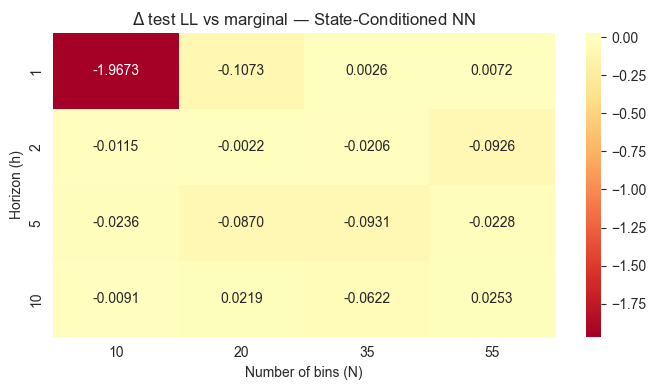

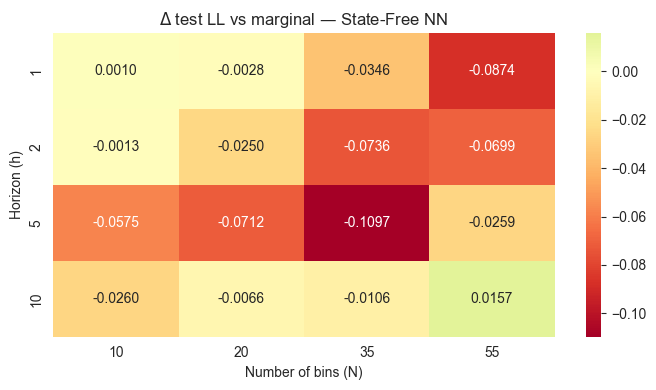

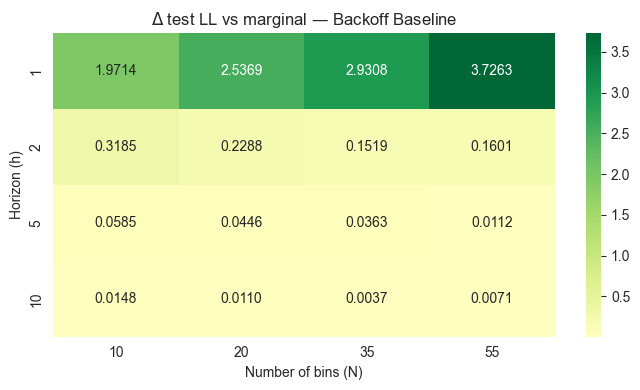

In [16]:
sns.set_style("whitegrid")

# ── Figure A: Heatmap — delta_LL (state-conditioned NN vs marginal) ──
def make_heatmap(df, model_name, title, filename):
    sub = df[df["model"] == model_name].copy()
    pivot = sub.pivot(index="h", columns="N", values="delta_ll")
    pivot = pivot.reindex(index=HORIZONS, columns=N_BINS_LIST)
    
    fig, ax = plt.subplots(figsize=(7, 4))
    sns.heatmap(pivot, annot=True, fmt=".4f", cmap="RdYlGn", center=0, ax=ax,
                xticklabels=N_BINS_LIST, yticklabels=HORIZONS)
    ax.set_xlabel("Number of bins (N)")
    ax.set_ylabel("Horizon (h)")
    ax.set_title(title)
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / filename, dpi=150, bbox_inches="tight")
    plt.show()

make_heatmap(df_results, "state_cond_nn",
             r"$\Delta$ test LL vs marginal — State-Conditioned NN",
             "A_heatmap_state_cond.png")

# ── Figure B: Heatmap — delta_LL (state-free NN vs marginal) ──
make_heatmap(df_results, "state_free_nn",
             r"$\Delta$ test LL vs marginal — State-Free NN",
             "B_heatmap_state_free.png")

# ── Figure C: Heatmap — delta_LL (backoff vs marginal) ──
make_heatmap(df_results, "backoff",
             r"$\Delta$ test LL vs marginal — Backoff Baseline",
             "C_heatmap_backoff.png")

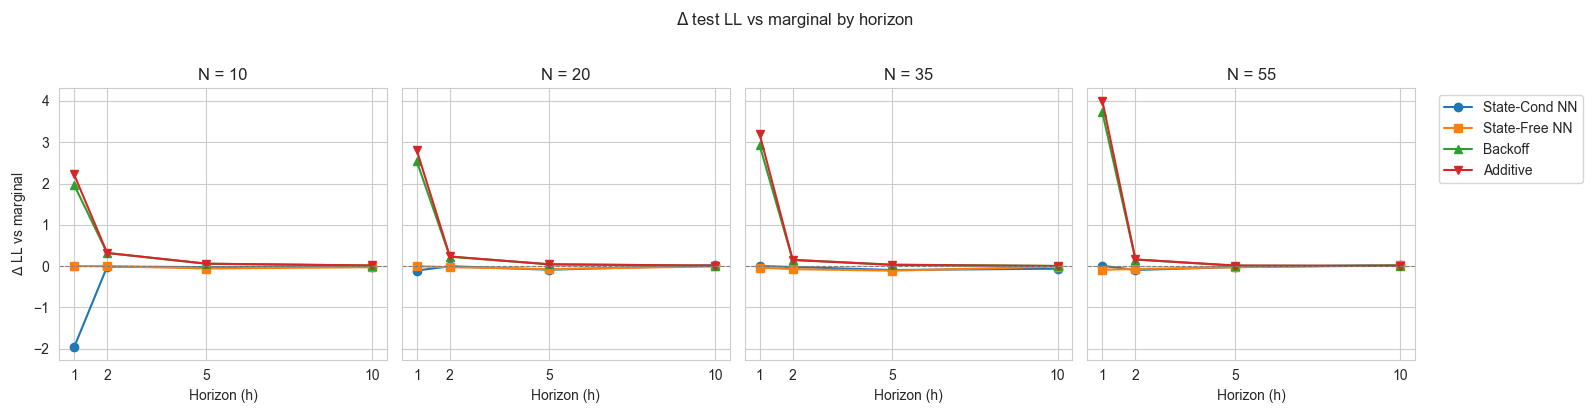

In [17]:
# ── Figure D: Line plot — deltaLL vs horizon for each N ──
fig, axes = plt.subplots(1, len(N_BINS_LIST), figsize=(4 * len(N_BINS_LIST), 4), sharey=True)

for i, N in enumerate(N_BINS_LIST):
    ax = axes[i]
    for model_name, label, marker in [
        ("state_cond_nn", "State-Cond NN", "o"),
        ("state_free_nn", "State-Free NN", "s"),
        ("backoff", "Backoff", "^"),
        ("additive", "Additive", "v"),
    ]:
        sub = df_results[(df_results["model"] == model_name) & (df_results["N"] == N)]
        sub = sub.sort_values("h")
        ax.plot(sub["h"], sub["delta_ll"], marker=marker, label=label)
    
    ax.axhline(0, color="gray", linestyle="--", linewidth=0.8)
    ax.set_title(f"N = {N}")
    ax.set_xlabel("Horizon (h)")
    if i == 0:
        ax.set_ylabel(r"$\Delta$ LL vs marginal")
    ax.set_xticks(HORIZONS)

axes[-1].legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.suptitle(r"$\Delta$ test LL vs marginal by horizon", y=1.02)
plt.tight_layout()
plt.savefig(FIGURES_DIR / "D_line_delta_ll_vs_horizon.png", dpi=150, bbox_inches="tight")
plt.show()

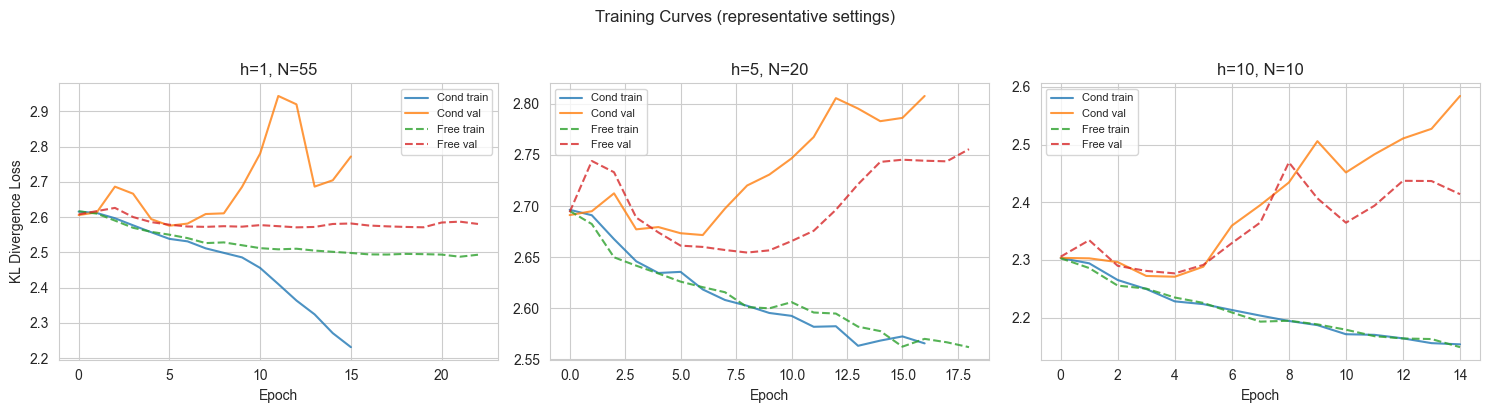

In [18]:
# ── Figure E: Training curves for representative settings ──
# Pick 3 settings: (h=1, N=55), (h=5, N=20), (h=10, N=10)
representative = [(1, 55), (5, 20), (10, 10)]
# Filter to those that exist in our grid
representative = [(h, N) for h, N in representative if (h, N) in all_histories]

fig, axes = plt.subplots(1, len(representative), figsize=(5 * len(representative), 4))
if len(representative) == 1:
    axes = [axes]

for i, (h, N) in enumerate(representative):
    ax = axes[i]
    hist = all_histories[(h, N)]
    
    ax.plot(hist["cond"]["train_loss"], label="Cond train", alpha=0.8)
    ax.plot(hist["cond"]["val_loss"], label="Cond val", alpha=0.8)
    ax.plot(hist["free"]["train_loss"], "--", label="Free train", alpha=0.8)
    ax.plot(hist["free"]["val_loss"], "--", label="Free val", alpha=0.8)
    
    ax.set_title(f"h={h}, N={N}")
    ax.set_xlabel("Epoch")
    if i == 0:
        ax.set_ylabel("KL Divergence Loss")
    ax.legend(fontsize=8)

plt.suptitle("Training Curves (representative settings)", y=1.02)
plt.tight_layout()
plt.savefig(FIGURES_DIR / "E_training_curves.png", dpi=150, bbox_inches="tight")
plt.show()

## 16. Final Summary

In [19]:
print("=" * 70)
print("FINAL RESULTS SUMMARY")
print("=" * 70)

# Pivot table: delta_LL for each model
for model_name in ["state_cond_nn", "state_free_nn", "backoff", "additive"]:
    sub = df_results[df_results["model"] == model_name]
    pivot = sub.pivot(index="h", columns="N", values="delta_ll")
    pivot = pivot.reindex(index=HORIZONS, columns=N_BINS_LIST)
    print(f"\n--- {model_name} (delta_LL vs marginal) ---")
    print(pivot.to_string(float_format=lambda x: f"{x:+.6f}"))

# Top settings
nn_results = df_results[df_results["model"].isin(["state_cond_nn", "state_free_nn"])]
top5 = nn_results.nlargest(5, "delta_ll")
print(f"\n--- Top 5 NN settings by delta_LL ---")
print(top5[["h", "N", "model", "delta_ll", "accuracy", "severity"]].to_string(index=False))

# Does any setting beat marginal robustly?
print(f"\n--- Does any NN beat marginal? ---")
for model_name in ["state_cond_nn", "state_free_nn"]:
    sub = df_results[df_results["model"] == model_name]
    n_positive = (sub["delta_ll"] > 0).sum()
    n_total = len(sub)
    best = sub.loc[sub["delta_ll"].idxmax()]
    print(f"  {model_name}: {n_positive}/{n_total} positive delta_LL")
    print(f"    Best: h={int(best['h'])}, N={int(best['N'])}, delta={best['delta_ll']:+.6f}")

# State-conditioned vs state-free advantage
print(f"\n--- State conditioning advantage ---")
for h in HORIZONS:
    for N in N_BINS_LIST:
        cond = df_results[(df_results["model"]=="state_cond_nn") & 
                          (df_results["h"]==h) & (df_results["N"]==N)]["delta_ll"].values[0]
        free = df_results[(df_results["model"]=="state_free_nn") & 
                          (df_results["h"]==h) & (df_results["N"]==N)]["delta_ll"].values[0]
        diff = cond - free
        print(f"  h={h:>2}, N={N:>2}: cond-free = {diff:+.6f} "
              f"({'cond better' if diff > 0 else 'free better'})")

print(f"\n--- Interpretation ---")
print("- Positive delta_LL means the model predicts better than marginal baseline")
print("- State-cond vs state-free difference reveals value of current-state information")
print("- Compare NN vs backoff baseline to assess whether neural model adds value")
print("=" * 70)

# Final file listing
print(f"\nSaved files:")
print(f"  {RESULTS_DIR / 'master_grid_results.csv'}")
for f in sorted(FIGURES_DIR.glob("*.png")):
    print(f"  {f}")
for f in sorted(RESULTS_DIR.glob("bin_edges_*.csv")):
    print(f"  {f}")

FINAL RESULTS SUMMARY

--- state_cond_nn (delta_LL vs marginal) ---
N         10        20        35        55
h                                         
1  -1.967344 -0.107254 +0.002609 +0.007168
2  -0.011472 -0.002195 -0.020552 -0.092629
5  -0.023601 -0.087008 -0.093147 -0.022820
10 -0.009118 +0.021921 -0.062181 +0.025339

--- state_free_nn (delta_LL vs marginal) ---
N         10        20        35        55
h                                         
1  +0.000992 -0.002820 -0.034556 -0.087375
2  -0.001308 -0.025035 -0.073578 -0.069896
5  -0.057490 -0.071210 -0.109665 -0.025916
10 -0.025977 -0.006648 -0.010568 +0.015738

--- backoff (delta_LL vs marginal) ---
N         10        20        35        55
h                                         
1  +1.971423 +2.536877 +2.930814 +3.726292
2  +0.318517 +0.228755 +0.151859 +0.160118
5  +0.058471 +0.044551 +0.036307 +0.011189
10 +0.014813 +0.011033 +0.003710 +0.007115

--- additive (delta_LL vs marginal) ---
N         10        20        3